In [1]:
import os 
import sys
sys.path.append('..')

In [2]:
# Import your module functions
from scripts.portfolio_optimization import *
import yfinance as yf

In [3]:
import scripts.ts_forecast as ts
df = ts.load_tesla_cleaned_data('../data/cleaned/TSLA_cleaned.csv')
train, test = ts.train_test_split(df)
arima_model = ts.fit_arima(train['Adj Close'])
lstm_model, scaler, look_back = ts.fit_lstm(train['Adj Close'], epochs=50)
lstm_forecast = ts.forecast_lstm(lstm_model, scaler, train['Adj Close'], look_back, len(test), test.index)
tsla_forecast_prices = lstm_forecast 

Epoch 1/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0094 - val_loss: 0.0013
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0010 - val_loss: 8.7210e-04
Epoch 8/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 8.7248e-04 - val_loss: 0.0011
Epoch 9/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 9.8268e-04 - val_loss: 8.1896e-04
Epoch 10/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 8.6295e-04 - val_loss: 0.0010
Epoch 11/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 8.6497e-04 - val_loss: 8.0751e-04
Epoch 12/50
59/59 ━━━━━━━━━━━━━━━━━

In [8]:
import pandas as pd 

# Function to load prices correctly
def load_prices(path):
    df = pd.read_csv(path, skiprows=[1], usecols=['Date', 'Adj Close'])
    df['Adj Close'] = pd.to_numeric(df['Adj Close'], errors='coerce')
    df = df.dropna()
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    return df['Adj Close']

# Load all assets
tsla_hist = load_prices('../data/TSLA_raw.csv')
bnd_hist  = load_prices('../data/BND_raw.csv')
spy_hist  = load_prices('../data/SPY_raw.csv')


In [9]:
# ------------------------------
# 2. Expected returns & Covariance
# ------------------------------
exp_returns_dict = get_expected_returns(tsla_forecast_prices, bnd_hist, spy_hist)
cov_matrix = get_covariance_matrix(tsla_hist, bnd_hist, spy_hist)

expected_returns_vector = list(exp_returns_dict.values())
asset_labels = list(exp_returns_dict.keys())

In [11]:
# ------------------------------
# 3. Optimize
# ------------------------------
max_sharpe_res = max_sharpe_ratio(expected_returns_vector, cov_matrix)
min_vol_res = min_volatility(expected_returns_vector, cov_matrix)

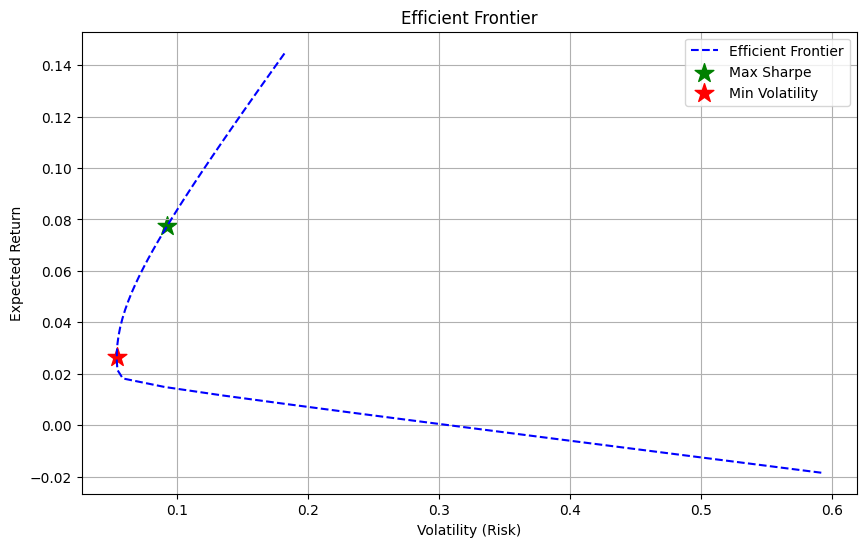

In [12]:
# ------------------------------
# 4. Efficient Frontier
# ------------------------------
frontier_df = efficient_frontier(expected_returns_vector, cov_matrix, num_points=50)
plot_efficient_frontier(frontier_df, max_sharpe_res, min_vol_res, expected_returns_vector, cov_matrix, asset_labels)

In [13]:
# ------------------------------
# 5. Recommended Portfolio
# ------------------------------
max_sharpe_perf = portfolio_performance(max_sharpe_res.x, expected_returns_vector, cov_matrix)
print("Max Sharpe Portfolio:")
print("Weights:", dict(zip(asset_labels, max_sharpe_res.x)))
print(f"Expected Return: {max_sharpe_perf[0]:.2%}")
print(f"Volatility: {max_sharpe_perf[1]:.2%}")
print(f"Sharpe Ratio: {max_sharpe_perf[2]:.2f}")

min_vol_perf = portfolio_performance(min_vol_res.x, expected_returns_vector, cov_matrix)
print("\nMin Volatility Portfolio:")
print("Weights:", dict(zip(asset_labels, min_vol_res.x)))
print(f"Expected Return: {min_vol_perf[0]:.2%}")
print(f"Volatility: {min_vol_perf[1]:.2%}")
print(f"Sharpe Ratio: {min_vol_perf[2]:.2f}")

Max Sharpe Portfolio:
Weights: {'TSLA': 1.0883965894553758e-13, 'BND': 0.5394609408653376, 'SPY': 0.46053905913455373}
Expected Return: 7.73%
Volatility: 9.22%
Sharpe Ratio: 0.84

Min Volatility Portfolio:
Weights: {'TSLA': 1.214306433183765e-17, 'BND': 0.9451743551382524, 'SPY': 0.0548256448617475}
Expected Return: 2.65%
Volatility: 5.40%
Sharpe Ratio: 0.49
